<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-packages" data-toc-modified-id="import-packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import packages</a></span></li><li><span><a href="#define-paths" data-toc-modified-id="define-paths-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>define paths</a></span></li><li><span><a href="#define-functions" data-toc-modified-id="define-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>define functions</a></span><ul class="toc-item"><li><span><a href="#figure-styles" data-toc-modified-id="figure-styles-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>figure styles</a></span></li><li><span><a href="#analyses" data-toc-modified-id="analyses-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>analyses</a></span></li></ul></li><li><span><a href="#SGC" data-toc-modified-id="SGC-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SGC</a></span></li><li><span><a href="#DGC" data-toc-modified-id="DGC-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>DGC</a></span></li></ul></div>

# import packages

In [2]:
import platform
import sys
os_name = platform.system()
if os_name == 'Darwin':
    sys.path.append('/Users/kperks/mnt/engram/scripts/Python/Analysis/')
if os_name == 'Linux':
    sys.path.append('/mnt/engram/scripts/Python/Analysis/')
from ClassDef_AmplitudeShift_Stable import AmpShift_Stable

from brian2 import *
import sympy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy import signal
from scipy import optimize
from scipy import stats
from scipy.stats import gaussian_kde
import pickle
import random


import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42


# define paths

In [3]:
exptpath = Path.cwd().resolve().parents[0] #assumes running notebook from /data_processed
data_folder = exptpath / 'data_raw'
figure_folder = Path.cwd().resolve().parents[2] / 'engram_share' / 'GranularCellPaperResources' / 'Figure_RawEPScomponents'
df_folder = exptpath / 'data_processed' / 'Figures_GRC_properties' / 'Unsubtracted_CvsU' / 'df_cmdintact'
meta_data_folder = exptpath / 'data_processed' / 'GRC_properties_Meta'

#for storing simulation states
sim_filename = 'grc_model_initialized.pickle'
sim_filepath = Path.cwd() / 'grc_model_simulations' / sim_filename #assumes running notebook from /data_processed

# define functions

## figure styles

In [4]:
def figsave(figure_folder,figname):
    plt.savefig(figure_folder / (figname + '.pdf'),format='pdf',dpi=300, transparent = True)
    
def create_fig():
    hfig = plt.figure(figsize=[1.5,1.5])
    ax = hfig.add_axes([0.2,0.2,0.7,0.7],frameon=False)
    return hfig,ax

def create_fig_tuning():
    figsize=[1.2,1.5]
    hfig = plt.figure(figsize = figsize) 
    ax = hfig.add_axes([0.3,0.2,0.6,0.7])
    return hfig,ax

def set_fig_style():
    rc = matplotlib.rcParams
    fontsize = 7
    rc['font.size'] = fontsize
    rc['axes.labelsize'] = fontsize
    rc['axes.titlesize'] = fontsize
    rc['axes.linewidth'] = 0.5
    rc['axes.labelpad'] = 0
    rc['font.family'] = 'sans-serif'
    rc['font.sans-serif'] = ['Helvetica','Arial','sans-serif']
    rc['xtick.major.width'] = 0.5
    rc['ytick.major.width'] = 0.5
    rc['xtick.minor.width'] = 0.5
    rc['ytick.minor.width'] = 0.5
    rc['xtick.major.size'] = 2
    rc['ytick.major.size'] = 2
    rc['xtick.minor.size'] = 2
    rc['ytick.minor.size'] = 2
    rc['xtick.major.pad'] = 0
    rc['ytick.major.pad'] = 0
    rc['xtick.minor.pad'] = 0
    rc['ytick.minor.pad'] = 0
    rc['ytick.labelsize'] = fontsize
    rc['xtick.labelsize'] = fontsize
    rc['pdf.fonttype'] = 42
    rc['ps.fonttype'] = 42
#     matplotlib.rcParams.update(rc)
    return rc

def plot_corr_matrix_multigauss(rv):
    hfig = plt.figure(figsize = (15,5))
    ax1 = hfig.add_axes([0.1,0.2,0.4,0.7])
    ax1.axis('scaled')
    ax2 = hfig.add_axes([0.5,0.2,0.4,0.7])
    ax2.axis('scaled')

    covmat = rv.covariance
    sns.heatmap(covmat,
            ax = ax1,
            annot=True,
            cbar = False,
            fmt="0.3f",
            cmap="YlGnBu",
            xticklabels=['stretch','tau','offset'],#range(np.shape(dataset)[1]),
            yticklabels=['stretch','tau','offset'])
    ax1.set_title("Covariance matrix")

    corrmat = correlation_from_covariance(covmat)
    sns.heatmap(corrmat,
            ax = ax2,
            annot=True,
            cbar = False,
            fmt="0.3f",
            cmap="YlGnBu",
            xticklabels=['stretch','tau','offset'],#range(np.shape(dataset)[1]),
            yticklabels=['stretch','tau','offset'])
    ax2.set_title("Correlation matrix")

## analyses

In [5]:
def exp_fit(x, a, k, b):
    return a*np.exp(x*k) + b

def get_example_cmd(exptname,boutstr,sweepdur):
#     exptname = '20191218_009'
#     sweepdur = 0.05
    expt = AmpShift_Stable()
    expt.load_expt(exptname, data_folder)
    expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

#     boutstr= '[expt.get_bout_win('R','Keyboard')[0],
#             expt.get_bout_win('R','Keyboard')[1],
#             expt.get_bout_win('N','Keyboard')[0],
#             expt.get_bout_win('N','Keyboard')[1]]''
    bout = eval(boutstr)
    marker_df = expt.get_marker_table()
    dt = expt.get_dt('lowgain')
    bout_df = expt.filter_marker_df_time(marker_df,bout)

    b_df = expt.filter_marker_df_code(bout_df,['B'])
    u_df = expt.filter_marker_df_code(bout_df,['U'])

    #from uncoupled trials get times for command responses
    cmd_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in u_df.time.values])

    xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_t,sweepdur)
    cmd_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]
    
    return xtime, cmd_

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

def exclude_HighThreshAff(meta_df):
    x = np.unique(meta_df.ampshift) #array([-40,-30,-20,-10,-5,0,5,10,20,30,40])
    spk_thresh = 12

    n_excluded = 0
    n_included = 0
    expt_excluded = []

    meta_params_df = pd.DataFrame()
    colors = ['blue','orange','brown','green']
    for i,animal in enumerate(np.unique(meta_df['animalID'])):
        animal_df = meta_df[meta_df['animalID'] == animal]
        print(str(animal) + '(' + colors[i] + ')' + ' has a total of ' + str(len(np.unique(animal_df['exptname']))) + ' afferents recorded')

        params_all = []
        sse_all = []
        df_all = []

        for name in np.unique(animal_df['exptname']):
            expt_df = animal_df[animal_df['exptname'] == name]
            try:
                x_data = expt_df.dropna(0).ampshift.values
                y_data =  expt_df.dropna(0).fsl.values
                if len(np.unique(x_data)) > 5 :
                    n_included += 1
                    spk_thresh = np.max(y_data)
                    params, params_covariance = optimize.curve_fit(exp_fit, x_data, y_data, 
                                                                   p0=[1,-0.05, 3],
                                                                   bounds = ([0,-1,1],[np.inf,0,10]),
                                                                   maxfev=1000)
                    params_all.append(params)
                    c = []
                    for x_,y_ in zip(x_data,y_data):
                        yh = exp_fit(x_,params[0],params[1],params[2])
                        s = np.std(y_data[x_data==x_]) #calc std of y measure at each x to adjust chi2
                        c.append(((y_ - yh)**2))
    #                     if s==0:
    #                         c.append(((y_ - yh)**2))
    #                     if s>0:
    #                         c.append(((y_ - yh)**2)/s**2)
                    sse_all.append(np.sum(c))    
                    df_all.append(len(y_data)-3)
                if len(np.unique(x_data)) <= 5:
                    n_excluded += 1
                    expt_excluded.append(name)
                    params = array([np.NaN,np.NaN,np.NaN])
                    params_all.append(params)
                    sse_all.append(np.NaN)    
                    df_all.append(len(y_data)-3)
            except:
                n_excluded += 1
                expt_excluded.append(name)
                params = array([np.NaN,np.NaN,np.NaN])
                params_all.append(params)
                sse_all.append(np.NaN)    
                df_all.append(len(y_data)-3)
                pass # doing nothing on exception

        exptname = animal_df.groupby('exptname').exptname.describe().top.values
        max_fsl = animal_df.groupby('exptname').fsl.max().values
        a = [p[0] for p in params_all]
        k = [p[1] for p in params_all]
        b = [p[2] for p in params_all]

        meta_params = {
            'exptname' : exptname,
            'animal' : animal,
            'stretch' : a,
            'tau' : k,
            'offset' : b,
            'max_fsl' : max_fsl,
            'sse' : sse_all,
            'df' : df_all
        }
        animal_df = pd.DataFrame(meta_params)
        meta_params_df = meta_params_df.append(animal_df,sort = False,ignore_index = False)


    print('number afferents excluded because first fsl threshold too high or could not be fit: ' + str(n_excluded))
    print('number afferents included (spike thresh at least 0%): ' + str(n_included))
    # plt.ylim(1.8,15)
    # plt.legend(bbox_to_anchor=(1.1, 1.05))
    
    return meta_params_df,expt_excluded

def assess_fits(meta_params_df):
    un_fit = meta_params_df[meta_params_df['sse'].gt(meta_params_df['sse'].quantile(.9))]

    well_fit = meta_params_df[meta_params_df['sse'].lt(meta_params_df['sse'].quantile(.9))]
    plt.figure(figsize = (2,4))
    well_fit.boxplot('sse')
    
    print(un_fit)

    return well_fit,un_fit


    
def calc_peaks(xtime,sweeps, order, min_peakt,threshold_h,dt):
    R = sweeps #np.mean(sweeps,1)-np.mean(sweeps,1)[0]
    
    nsamp=int(order/dt) #the window of comparison in nsamp for order; 2msec seemed good
    epsp_ = signal.argrelextrema(R,np.greater_equal,order = nsamp)[0]
    epsp_ = epsp_[np.where((epsp_*dt)>min_peakt)[0]]
    epsp = []
    measure = epsp_
    for i in measure:
        lb = int(min_peakt/dt)
        rb = len(R)-1
        min_height = np.min([abs(R[i]-R[lb]),abs(R[i]-R[rb])])
        if min_height>threshold_h:
            epsp.append(i)
    if len(epsp)>0:
        epsp = np.min(epsp)
    elif len(epsp)==0:
        epsp = np.NaN

    R_filt = R #signal.medfilt(R,[11])
    y = signal.medfilt(np.concatenate([[0],np.diff(R_filt)]),[25]) #-threshold_dvdt
    accel = signal.medfilt(np.concatenate([[0],np.diff(y)]),[11])   

    dvdt_start = int(0.002/dt)
    if ~np.isnan([epsp]).any():
        epsp_t = xtime[epsp]
        max_dvdt = np.max(y[dvdt_start:epsp])
        dvdt_threshold = np.max([0.01,0.15*max_dvdt])

        onset_options = np.where((np.sign(y-dvdt_threshold)>0) & (np.sign(accel)>=0))[0]
        valid_onsets = onset_options[(onset_options>dvdt_start)&(onset_options<epsp)]
        if len(valid_onsets) > 0:
            if (epsp_t-(np.min(valid_onsets)*dt)) > 0: #ensure that onset is before peak
                epsp_onset_ind = np.min(valid_onsets) #min after stim artifact
                epsp_amp = R[epsp]-R[epsp_onset_ind]
                epsp_onset = xtime[epsp_onset_ind]
            elif (epsp_t-(np.min(valid_onsets)*dt)) <= 0:
                epsp_t = np.NaN
                epsp_onset = np.NaN
                epsp_amp = 0
        elif len(valid_onsets)==0:
            epsp_t = np.NaN
            epsp_onset = np.NaN
            epsp_amp = 0
    elif np.isnan([epsp]).any():
        epsp_t = np.NaN
        epsp_onset = np.NaN
        epsp_amp = 0    

    return epsp_t, epsp_amp, epsp_onset


# SGC

In [6]:
all_exptname_uc = {
    '20200718_000' : '[expt.get_bout_win("R","Keyboard")[0],expt.get_bout_win("R","Keyboard")[1]]',
    '20200606_001' : '[expt.get_bout_win("R","Keyboard")[1]]',
    '20200607_000' : '[expt.get_bout_win("R","Keyboard")[1],expt.get_bout_win("R","Keyboard")[2]]',
    '20200524_002' : '[expt.get_bout_win("R","Keyboard")[1]]',
    '20200109_004' : '[expt.get_bout_win("R","Keyboard")[2]]'
#     '20200607_003' : '[expt.get_bout_win('R',"Keyboard")[0]]' is this an sGRC?
}

In [13]:
# save array of uncoupled avg for each cell as a dictionary entry...
# then save dictionary
sweepdur = 0.1
wavmat = {}
cmd_response_ = {}
meta_df = pd.DataFrame()
for exptname,boutstr in all_exptname_uc.items():
    # exptname = '20200719_004'
    # boutstr = '[expt.get_bout_win("R","Keyboard")[3]]'
    expt = AmpShift_Stable()
    expt.load_expt(exptname, data_folder)

    expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
    expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

    bout_uc = eval(boutstr)
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    b_df = expt.filter_marker_df_code(bout_df,['B'])
    u_df = expt.filter_marker_df_code(bout_df,['U'])
    c_df = expt.filter_marker_df_code(bout_df,['C'])
    u_t = u_df.time.values
    c_t = c_df.time.values
    #from uncoupled trials get times for command responses
    cmd_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in trial_df.time.values if count_nonzero(b_df.time.values<t)>0])

    if exptname == '20200606_001': #had to switch to freerun during unpaired bout so can only use beginning for c_latency calc
        cmd_t = cmd_t[cmd_t<116.9]
        c_t = c_t[c_t<116.9]
        
    # #calculate time will need to offset command response by to subtract from coupled estim response
    #use coupled trials
    cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t if count_nonzero(b_df.time.values<t)>0])
    c_t_used = np.asarray([t for t in c_t if count_nonzero(b_df.time.values<t)>0])
    c_latency = np.median(c_t_used-cmd_coupled_t)
    
    xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_t+c_latency,sweepdur)
    cmd_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

    xtime,sweeps = expt.get_sweepsmat('lowgain',u_t,sweepdur)
    u_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

    xtime,sweeps = expt.get_sweepsmat('lowgain',c_t,sweepdur)
    c_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['U'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

    min_peakt = 0.002 #(s)
    threshold_h = 1 #(mV)
    subsweepdur = 0.04
    dt = expt.get_dt('lowgain')

    xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
    peakAmp = []
    peakT = []
    sweeps = np.asarray([sweep[int(min_peakt/dt):int(subsweepdur/dt)]-sweep[0] for sweep in sweeps.T]).T
    cmd_clip = cmd_[int(min_peakt/dt):int(subsweepdur/dt)]-cmd_[0]

    xtime = xtime[int(min_peakt/dt):int(subsweepdur/dt)]
    for sweep in sweeps.T:
        sweep = sweep + cmd_clip
        peakAmp.append(sweep[np.argmax(sweep)])
        if sweep[np.argmax(sweep)]>=threshold_h:
            peakT.append(xtime[np.argmax(sweep)])
        if sweep[np.argmax(sweep)]<threshold_h:
            peakT.append(np.NaN)

    trial_df.insert(np.shape(trial_df)[1],'peakAmp',peakAmp)
    trial_df.insert(np.shape(trial_df)[1],'peakT',peakT)
    trial_df.insert(np.shape(trial_df)[1],'exptname',exptname)
    meta_df = meta_df.append(trial_df,sort = False,ignore_index = False)

    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values #- 0.005
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1)+cmd_)
    trialmat = np.asarray(trialmat).T 
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    wavmat[exptname] = trialmat
    
    cmd_response_[exptname] = cmd_[0:int(0.05/dt)]-cmd_[0]

/Users/kperks/mnt/engram/spikedata/data_raw/20200718/20200718_000.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200606/20200606_001.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_000.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200524/20200524_002.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200109/20200109_004.smr


In [14]:
pickle_out = open(df_folder / 'SGC_predicted_wavmat.pickle','wb')
pickle.dump(wavmat, pickle_out)
pickle_out.close()

pickle_out = open(df_folder / 'SGC_cmd_wavmat.pickle','wb')
pickle.dump(cmd_response_, pickle_out)
pickle_out.close()

meta_df.to_csv('DF_SGC_PredictedAmpShift_revised5Dec.csv')

In [9]:
sweepdur = 0.1
exptname = '20200606_001'
boutstr = '[expt.get_bout_win("R","Keyboard")[1]]'
# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

bout_uc = eval(boutstr)
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

b_df = expt.filter_marker_df_code(bout_df,['B'])
u_df = expt.filter_marker_df_code(bout_df,['U'])
c_df = expt.filter_marker_df_code(bout_df,['C'])
u_t = u_df.time.values
c_t = c_df.time.values
#from uncoupled trials get times for command responses
cmd_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in trial_df.time.values if count_nonzero(b_df.time.values<t)>0])

if exptname == '20200606_001': #had to switch to freerun during unpaired bout so can only use beginning for c_latency calc
    cmd_t = cmd_t[cmd_t<116.9]
    c_t = c_t[c_t<116.9]

# #calculate time will need to offset command response by to subtract from coupled estim response
#use coupled trials
cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t if count_nonzero(b_df.time.values<t)>0])
c_t_used = np.asarray([t for t in c_t if count_nonzero(b_df.time.values<t)>0])
c_latency = np.median(c_t_used-cmd_coupled_t)

xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_t+c_latency,sweepdur)
cmd_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

In [11]:
xtime,sweeps = expt.get_sweepsmat('lowgain',u_t,sweepdur)
u_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

xtime,sweeps = expt.get_sweepsmat('lowgain',c_t,sweepdur)
c_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

min_peakt = 0.002 #(s)
threshold_h = 1 #(mV)
subsweepdur = 0.04
dt = expt.get_dt('lowgain')

xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
peakAmp = []
peakT = []
sweeps = np.asarray([sweep[int(min_peakt/dt):int(subsweepdur/dt)]-sweep[0] for sweep in sweeps.T]).T
cmd_clip = cmd_[int(min_peakt/dt):int(subsweepdur/dt)]-cmd_[0]

xtime = xtime[int(min_peakt/dt):int(subsweepdur/dt)]
for sweep in sweeps.T:
    sweep = sweep + cmd_clip
    peakAmp.append(sweep[np.argmax(sweep)])
    if sweep[np.argmax(sweep)]>=threshold_h:
        peakT.append(xtime[np.argmax(sweep)])
    if sweep[np.argmax(sweep)]<threshold_h:
        peakT.append(np.NaN)

trial_df.insert(np.shape(trial_df)[1],'peakAmp',peakAmp)
trial_df.insert(np.shape(trial_df)[1],'peakT',peakT)
trial_df.insert(np.shape(trial_df)[1],'exptname',exptname)
# meta_df = meta_df.append(trial_df,sort = False,ignore_index = False)

trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values #- 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1)+cmd_)
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
# wavmat[exptname] = trialmat

# cmd_response_[exptname] = cmd_[0:int(0.05/dt)]-cmd_[0]

# DGC

In [6]:
### DGC

all_exptname_uc = {
    '20200719_004' : '[expt.get_bout_win("R","Keyboard")[3]]',
    '20200719_001' : '[expt.get_bout_win("R","Keyboard")[0]]',
    '20200606_005' : '[expt.get_bout_win("R","Keyboard")[1]]',
    '20200607_005' : '[expt.get_bout_win("R","Keyboard")[0],expt.get_bout_win("R","Keyboard")[1]]',
    '20200607_004' : '[expt.get_bout_win("R","Keyboard")[0]]',
    '20200607_002' : '[expt.get_bout_win("R","Keyboard")[0],expt.get_bout_win("R","Keyboard")[1]]',
    '20200525_001' : '[expt.get_bout_win("R","Keyboard")[0],expt.get_bout_win("R","Keyboard")[1]]',
    '20200525_006' : '[expt.get_bout_win("R","Keyboard")[0]]',
    '20200312_002' : '[expt.get_bout_win("R","Keyboard")[0]]',
    '20200227_000' : '[expt.get_bout_win("R","Keyboard")[0]]',
    '20200226_002' : '[expt.get_bout_win("R","Keyboard")[0]]',
    '20200225_000' : '[expt.get_bout_win("R","Keyboard")[0]]',
    '20200115_002' : '[expt.get_bout_win("R","Keyboard")[0]]'
}


In [76]:
# save array of uncoupled avg for each cell as a dictionary entry...
# then save dictionary
sweepdur = 0.1
wavmat = {}
cmd_response_ = {}
meta_df = pd.DataFrame()
for exptname,boutstr in all_exptname_uc.items():
    # exptname = '20200719_004'
    # boutstr = '[expt.get_bout_win("R","Keyboard")[3]]'
    expt = AmpShift_Stable()
    expt.load_expt(exptname, data_folder)

    expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
    expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

    marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

    bout_uc = eval(boutstr)
    bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
    trial_df = expt.filter_marker_df_code(bout_df,['T'])

    b_df = expt.filter_marker_df_code(bout_df,['B'])
    u_df = expt.filter_marker_df_code(bout_df,['U'])
    c_df = expt.filter_marker_df_code(bout_df,['C'])
    u_t = u_df.time.values
    c_t = c_df.time.values
    #from uncoupled trials get times for command responses
    cmd_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in trial_df.time.values if count_nonzero(b_df.time.values<t)>0])

    if exptname == '20200225_000': #had to switch to freerun during unpaired bout so can only use beginning for c_latency calc
        cmd_t = cmd_t[cmd_t<139]
        c_t = c_t[c_t<139]
    
    # #calculate time will need to offset command response by to subtract from coupled estim response
    #use coupled trials
    cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t if count_nonzero(b_df.time.values<t)>0])
    c_t_used = np.asarray([t for t in c_t if count_nonzero(b_df.time.values<t)>0])
    c_latency = np.median(c_t_used-cmd_coupled_t)
    
    if exptname == '20200606_005': #R bout is all freerun 
    #so need to use a different bout to calculate coupled latency and also get cmd average
    # but also this cell only has one or two coupled trials per amp, so won't go into stats for individ cell anyway
        bout_df = expt.filter_marker_df_time(marker_df,[expt.get_bout_win("B","Keyboard")[0]])
        b_df = expt.filter_marker_df_code(bout_df,['B'])
        cmd_t = b_df.time.values
        
        bout_df = expt.filter_marker_df_time(marker_df,[expt.get_bout_win("N","Keyboard")[0]])
        b_df = expt.filter_marker_df_code(bout_df,['B'])
        c_df = expt.filter_marker_df_code(bout_df,['C'])
        cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_df.time.values if count_nonzero(b_df.time.values<t)>0])
        c_t_used = np.asarray([t for t in c_df.time.values if count_nonzero(b_df.time.values<t)>0])
        c_latency = np.median(c_t_used-cmd_coupled_t)


    xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_t+c_latency,sweepdur)
    cmd_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

    xtime,sweeps = expt.get_sweepsmat('lowgain',u_t,sweepdur)
    u_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

    xtime,sweeps = expt.get_sweepsmat('lowgain',c_t,sweepdur)
    c_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

    eventDur = 0.001
    xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
    event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

    base_df = expt.filter_marker_df_code(bout_df,['U'])
    xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
    event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

    ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
    trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

    min_peakt = 0.002 #(s)
    threshold_h = 1 #(mV)
    subsweepdur = 0.04
    dt = expt.get_dt('lowgain')

    xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
    peakAmp = []
    peakT = []
    sweeps = np.asarray([sweep[int(min_peakt/dt):int(subsweepdur/dt)]-sweep[0] for sweep in sweeps.T]).T
    cmd_clip = cmd_[int(min_peakt/dt):int(subsweepdur/dt)]-cmd_[0]

    xtime = xtime[int(min_peakt/dt):int(subsweepdur/dt)]
    for sweep in sweeps.T:
        sweep = sweep + cmd_clip
        peakAmp.append(sweep[np.argmax(sweep)])
        if sweep[np.argmax(sweep)]>=threshold_h:
            peakT.append(xtime[np.argmax(sweep)])
        if sweep[np.argmax(sweep)]<threshold_h:
            peakT.append(np.NaN)

    trial_df.insert(np.shape(trial_df)[1],'peakAmp',peakAmp)
    trial_df.insert(np.shape(trial_df)[1],'peakT',peakT)
    trial_df.insert(np.shape(trial_df)[1],'exptname',exptname)
    meta_df = meta_df.append(trial_df,sort = False,ignore_index = False)

    trialmat = []
    for a in np.unique(trial_df['ampshift']):
        theseT = trial_df[trial_df['ampshift']==a].time.values #- 0.005
        xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
        trialmat.append(np.mean(R,1)+cmd_)
    trialmat = np.asarray(trialmat).T 
    trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
    wavmat[exptname] = trialmat
    
    cmd_response_[exptname] = cmd_[0:int(0.05/dt)]-cmd_[0]

/Users/kperks/mnt/engram/spikedata/data_raw/20200719/20200719_004.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200719/20200719_001.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200606/20200606_005.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_005.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_004.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200607/20200607_002.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200525/20200525_001.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200525/20200525_006.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200312/20200312_002.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200227/20200227_000.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200226/20200226_002.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200225/20200225_000.smr
/Users/kperks/mnt/engram/spikedata/data_raw/20200115/20200115_002.smr


In [77]:
pickle_out = open(df_folder / 'DGC_cmd_wavmat.pickle','wb')
pickle.dump(cmd_response_, pickle_out)
pickle_out.close()

In [78]:
pickle_out = open(df_folder / 'DGC_predicted_wavmat.pickle','wb')
pickle.dump(wavmat, pickle_out)
pickle_out.close()

meta_df.to_csv('DF_DGC_PredictedAmpShift_revised5Dec.csv')

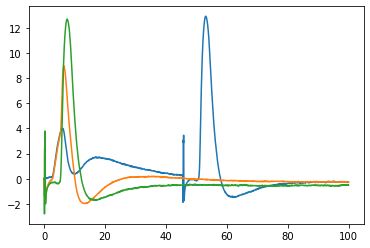

In [12]:
plt.plot(xtime,cmd_)
plt.plot(xtime,c_)
plt.plot(xtime,u_)

In [62]:
exptname = '20200225_000'
boutstr = '[expt.get_bout_win("R","Keyboard")[0]]'

# expt = AmpShift_Stable()
# expt.load_expt(exptname, data_folder)

expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')

marker_df = expt.get_marker_table() #access with : getattr(expt,'marker_df')

bout_uc = eval(boutstr)
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])

b_df = expt.filter_marker_df_code(bout_df,['B'])
u_df = expt.filter_marker_df_code(bout_df,['U'])
c_df = expt.filter_marker_df_code(bout_df,['C'])
u_t = u_df.time.values
c_t = c_df.time.values
#from uncoupled trials get times for command responses
cmd_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in trial_df.time.values if count_nonzero(b_df.time.values<t)>0])
# cmd_t = b_df.time.values[b_df.time.values<139.5]
# cmd_t = cmd_t[cmd_t<139.5]
# #calculate time will need to offset command response by to subtract from coupled estim response
#use coupled trials

if expt == '20200225_000':
    cmd_t = cmd_t[cmd_t<139]
    c_t = c_t[c_t<139]


cmd_coupled_t = np.asarray([np.max(b_df.time.values[b_df.time.values<t]) for t in c_t if count_nonzero(b_df.time.values<t)>0])
c_t_used = np.asarray([t for t in c_t if count_nonzero(b_df.time.values<t)>0])
c_latency = np.median(c_t_used-cmd_coupled_t)


xtime,sweeps = expt.get_sweepsmat('lowgain',cmd_t+c_latency,sweepdur)
cmd_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

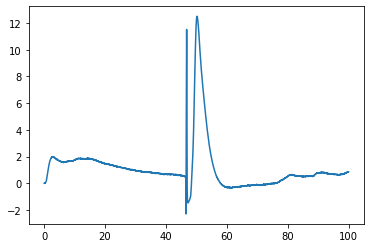

In [64]:
cmd_t
# xtime,sweeps = expt.get_sweepsmat('lowgain',b_df.time.values[b_df.time.values<139.5],sweepdur)
plt.plot(xtime,cmd_);

In [9]:
xtime,sweeps = expt.get_sweepsmat('lowgain',u_t,sweepdur)
u_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

xtime,sweeps = expt.get_sweepsmat('lowgain',c_t,sweepdur)
c_ = np.mean(sweeps,1)-np.mean(sweeps,1)[0]

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)

min_peakt = 0.002 #(s)
threshold_h = 1 #(mV)
subsweepdur = 0.05
dt = expt.get_dt('lowgain')

xtime,sweeps = expt.get_sweepsmat('lowgain',trial_df.time.values,sweepdur)
peakAmp = []
peakT = []
sweeps = np.asarray([sweep[int(min_peakt/dt):int(subsweepdur/dt)]-sweep[0] for sweep in sweeps.T]).T
cmd_clip = cmd_[int(min_peakt/dt):int(subsweepdur/dt)]-cmd_[0]

xtime = xtime[int(min_peakt/dt):int(subsweepdur/dt)]
for sweep in sweeps.T:
    sweep = sweep + cmd_clip
    peakAmp.append(sweep[np.argmax(sweep)])
    if sweep[np.argmax(sweep)]>=threshold_h:
        peakT.append(xtime[np.argmax(sweep)])
    if sweep[np.argmax(sweep)]<threshold_h:
        peakT.append(np.NaN)

trial_df.insert(np.shape(trial_df)[1],'peakAmp',peakAmp)
trial_df.insert(np.shape(trial_df)[1],'peakT',peakT)
trial_df.insert(np.shape(trial_df)[1],'exptname',exptname)
# meta_df = meta_df.append(trial_df,sort = False,ignore_index = False)

trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values #- 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1)+cmd_)
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T
# wavmat[exptname] = trialmat

# cmd_response_[exptname] = cmd_[0:int(0.05/dt)]-cmd_[0]

/Users/kperks/mnt/engram/spikedata/data_raw/20200225/20200225_000.smr


In [ ]:
cmd_response_[exptname] = 